In [33]:
# PyTorch modules for tensor operations, neural network layers, and data utilities.
import torch
import torch.nn as nn  # All neural network modules
from torch.utils import data
from sklearn.decomposition import PCA  # To visualize high-dimensional data
import torch.nn.functional as F  # includes various activation functions and loss functions
import pandas as pd  # For handling data in tabular format
import numpy as np  # For numerical operations
import matplotlib.pyplot as plt  # For plotting and data visualization
import random  # For shuffling data and introducing randomness
from sklearn.metrics import confusion_matrix  # To evaluate classification performance

In [34]:
# Paths to datasets
train_file = "/media/danissa/SSD/Kannada-MNIST/train.csv"
test_file = "/media/danissa/SSD/Kannada-MNIST/test.csv"

In [35]:
# Function to load data from CSV files based on the specified dataset ('train', 'validation', or 'test')
def loadData(dataset: str = "train"):
    # Read CSV file based on the dataset
    if dataset == "train" or dataset == "validation":
        df = pd.read_csv(train_file)
    else:
        df = pd.read_csv(test_file)

    # Extract pixel values and labels, normalize pixel values to [0, 1]
    data = torch.from_numpy(df.iloc[:, 1:].values).to(dtype=torch.uint8) / 255.0  # Normalize to [0, 1]
    targets = torch.from_numpy(df.iloc[:, 0].values).to(dtype=torch.uint8)  # Get labels

    # Return data and labels based on the specified dataset
    if dataset == "train":
        return data[:48000, :], targets[:48000]
    elif dataset == "validation":
        return data[48000:, :], targets[48000:]
    else:
        return data, targets  # Return all data for testing

In [36]:
# Custom dataset class for PyTorch DataLoader
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, dataset):
        self.data, self.targets = loadData(dataset)

    # Get the length of the dataset
    def __len__(self):
        return len(self.data)

    # Get data and label for a specific index
    def __getitem__(self, index):
        return self.data[index], self.targets[index]


# Dictionary of PyTorch DataLoader instances for different datasets
loaders = {
    "train": data.DataLoader(CustomDataset(dataset="train"),
                             batch_size=100,
                             shuffle=True,
                             num_workers=0),  # DataLoader for training set with shuffling
    "validation": data.DataLoader(CustomDataset(dataset="validation"),
                                  batch_size=100,
                                  shuffle=True,
                                  num_workers=0),  # DataLoader for validation set with shuffling
    "test": data.DataLoader(CustomDataset(dataset="test"),
                            batch_size=100,
                            shuffle=False,
                            num_workers=0),  # DataLoader for test set without shuffling
}


In [37]:
# A class for MLP
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        # Define the layers of the network. We create three fully connected layers.
        self.fc1 = nn.Linear(784, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        # x is the mnist images and we run it through fc1, fc2, and fc3.
        # we also add a ReLU activation function in between.

        x = self.fc1(x)
        x = F.relu(x)

        x = self.fc2(x)
        x = F.relu(x)

        x = self.fc3(x)
        return x

In [38]:
# A class for CNN
class CNN(nn.Module):

    def __init__(self):
        super(CNN, self).__init__()

        # Two convolutional layers
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=10, kernel_size=3)
        self.conv2 = nn.Conv2d(in_channels=10, out_channels=20, kernel_size=3)
        self.conv2_dropout = nn.Dropout2d()  # some random values are set to zero to prevent overfitting

        # The data is passed to the fully-connected layers (the dense layers)
        self.fc1 = nn.Linear(8000, 1000)
        self.fc2 = nn.Linear(1000, 100)
        self.fc3 = nn.Linear(100, 10)

    def forward(self, x):
        x = x.view(-1, 1, 28, 28)  # Re-shape the data
        x = F.relu(F.max_pool2d(self.conv1(x), kernel_size=3, stride=1))
        x = F.relu(F.max_pool2d(self.conv2_dropout(self.conv2(x)), kernel_size=3, stride=1))
        x = x.view(-1, 8000)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, 0.2, training=self.training)
        x = F.relu(self.fc2(x))
        x = self.fc3(x)

        return x

In [39]:
# A class for RNN (many-to-one)
class RNN(nn.Module):
    def __init__(self):
        super(RNN, self).__init__()
        self.rnn = nn.RNN(28, 256, 2, batch_first=True)
        self.fc3 = nn.Linear(256 * 28, 10)

    def forward(self, x):
        x = x.view(-1, 28, 28)  # Re-shape

        # Set initial hidden states
        h0 = torch.zeros(2, x.size(0), 256).to(device)

        # Forward propagate
        out, _ = self.rnn(x, h0)
        out = out.reshape(out.shape[0], -1)

        # Decode the hidden state of the last time step
        out = self.fc3(out)
        return out

In [40]:
# Set device cuda for GPU if it's available otherwise run on the CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [41]:
criterion = nn.CrossEntropyLoss()

In [42]:
# Hyperparameter (# epochs)
epochs = 10

In [43]:
# Train Network
def trainModel(model):
    model.train()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    accuracies = []
    val_accuracies = []
    loss_list = []
    val_losses = []

    for epoch in range(1, epochs + 1):
        running_loss = []
        for batch_idx, (data, target) in enumerate(loaders['train']):
            data, target = data.to(device), target.to(device)

            # Forward prop
            output = model(data)
            loss = criterion(output, target)

            # Backward prop
            optimizer.zero_grad()
            loss.backward()

            # GD update
            optimizer.step()

            running_loss.append(loss.item())  # Record the training loss for this batch

            # Print progress every 20 batches
            if batch_idx % 20 == 0:
                print(
                    f'Train Epoch: {epoch} [{batch_idx * len(data)} / {len(loaders["train"].dataset)} '
                    f'({100. * batch_idx / len(loaders["train"]):.0f}%)]')

        # Validation for plotting the accuracy and loss curves
        val_loss = []
        correct = 0
        model.eval()
        with torch.no_grad():
            for data, target in loaders["validation"]:
                data, target = data.to(device), target.to(device)
                output = model(data)

                val_loss.append(criterion(output, target).item())
                pred = output.argmax(dim=1, keepdim=True)
                correct += pred.eq(target.view_as(pred)).sum().item()

        # Calculate and store validation accuracy and loss
        model.train()
        val_accuracies.append(100. * correct / len(loaders["validation"].dataset))
        val_losses.append(np.sum(val_loss) / len(val_loss))

        # Calculate and store training accuracy
        loss_list.append(np.sum(running_loss) / len(running_loss))
        accuracy = check_accuracy(model, 'train')
        accuracies.append(accuracy.item() * 100.)
        print(f"Epoch {epoch}/{epochs}, Accuracy on train set: {accuracy * 100:.2f}%")

    # Return lists of accuracies and losses for plotting
    return accuracies, loss_list, val_accuracies, val_losses

In [44]:
def validateModel(model):
    model.eval()  # Set the model to evaluation mode

    # Initialize variables to store evaluation metrics
    val_loss = 0
    correct = 0
    true_labels = []
    predicted_labels = []
    embeddings = []
    validation_losses = []
    accuracies = []

    # Disable gradient computation during validation
    with torch.no_grad():
        # Iterate over batches in the validation data
        for data, target in loaders["validation"]:
            data, target = data.to(device), target.to(device)
            output = model(data)

            # Collect embeddings for visualization
            embeddings.extend(output.cpu().numpy())

            val_loss += criterion(output, target).item()  # Calculate validation loss

            # Calculate the number of correct predictions
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

            # Store true and predicted labels for later analysis
            true_labels.extend(target.cpu().numpy())
            predicted_labels.extend(pred.cpu().numpy().squeeze())

    # Calculate average test loss and accuracy
    val_loss = val_loss / len(loaders["validation"].dataset)
    accuracy = 100. * correct / len(loaders["validation"].dataset)
    print(f'\nValidation set: Average loss: {val_loss:.4f}, Accuracy: {accuracy:.2f}%\n')

    # Append the results to lists for plotting
    validation_losses.append(val_loss)
    accuracies.append(accuracy)

    # Display confusion matrix and visualize samples
    print("Confusion Matrix:")
    print(confusion_matrix(true_labels, predicted_labels))
    visualize_samples(true_labels, predicted_labels)

    embeddings = np.array(embeddings)  # Convert embeddings to numpy array

    # Perform PCA for 3D visualization
    pca = PCA(n_components=3)
    pca_results = pca.fit_transform(embeddings)

    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_subplot(111, projection='3d')

    # Visualize using matplotlib scatter plot based on predicted labels
    scatter = ax.scatter(pca_results[:, 0], pca_results[:, 1], pca_results[:, 2], c=predicted_labels, cmap='viridis')
    if isinstance(model, MLP):
        ax.set_title('3D PCA Visualization of Validation Set Embeddings (MLP)')
    elif isinstance(model, CNN):
        ax.set_title('3D PCA Visualization of Validation Set Embeddings (CNN)')
    elif isinstance(model, RNN):
        ax.set_title('3D PCA Visualization of Validation Set Embeddings (RNN)')

    ax.set_xlabel('Principal Component 1')
    ax.set_ylabel('Principal Component 2')
    ax.set_zlabel('Principal Component 3')
    ax.legend(*scatter.legend_elements(), title='Predicted Label')
    plt.show()

In [45]:
def testModel(model):
    model.eval()  # Set the model to evaluation mode
    outputs = None   # Initialize variable to store test outputs

    with torch.no_grad():
        for data, _ in loaders["test"]:  # Iterate over batches in the test data
            data = data.to(device)
            output = model(data)

            # Concatenate model outputs for later analysis
            if outputs is None:
                outputs = output.cpu().numpy()
            else:
                outputs = np.concatenate((outputs, output.cpu().numpy()))
    return outputs

In [46]:
def check_accuracy(model, dataset: str):
    # Initialize variables to count correct predictions and total samples
    num_correct = 0
    num_samples = 0

    model.eval()

    with torch.no_grad():
        for x, y in loaders[dataset]:
            x, y = x.to(device=device), y.to(device=device)

            # Get model predictions
            scores = model(x)
            _, predictions = scores.max(1)

            # Count correct predictions and total samples
            num_correct += (predictions == y).sum()
            num_samples += predictions.size(0)

    # Set the model back to training mode
    model.train()

    return num_correct / num_samples

In [47]:
def visualize_samples(true_labels, predicted_labels):
    # Get random samples
    random_indices = random.sample(range(len(true_labels)), 16)
    random_samples = [(true_labels[i], predicted_labels[i]) for i in random_indices]

    plt.figure(figsize=(12, 8))
    for i, (true_label, predicted_label) in enumerate(random_samples):
        # Load the image corresponding to the true label
        image_index = true_label
        image_data, _ = loaders["validation"].dataset[image_index]
        image = image_data.view(28, 28).cpu().numpy()

        plt.subplot(4, 4, i + 1)
        plt.imshow(image, cmap='gray')
        plt.title(f'True: {true_label}, Predicted: {predicted_label}')
        plt.axis('off')

    plt.show()

In [48]:
# Initialize networks
mlp = MLP().to(device)
cnn = CNN().to(device)
rnn = RNN().to(device)

In [49]:
x = np.linspace(1, epochs, epochs).astype(int)



Training MLP ...

Train Epoch: 1 [0 / 48000 (0%)]
Train Epoch: 1 [2000 / 48000 (4%)]
Train Epoch: 1 [4000 / 48000 (8%)]
Train Epoch: 1 [6000 / 48000 (12%)]
Train Epoch: 1 [8000 / 48000 (17%)]
Train Epoch: 1 [10000 / 48000 (21%)]
Train Epoch: 1 [12000 / 48000 (25%)]
Train Epoch: 1 [14000 / 48000 (29%)]
Train Epoch: 1 [16000 / 48000 (33%)]
Train Epoch: 1 [18000 / 48000 (38%)]
Train Epoch: 1 [20000 / 48000 (42%)]
Train Epoch: 1 [22000 / 48000 (46%)]
Train Epoch: 1 [24000 / 48000 (50%)]
Train Epoch: 1 [26000 / 48000 (54%)]
Train Epoch: 1 [28000 / 48000 (58%)]
Train Epoch: 1 [30000 / 48000 (62%)]
Train Epoch: 1 [32000 / 48000 (67%)]
Train Epoch: 1 [34000 / 48000 (71%)]
Train Epoch: 1 [36000 / 48000 (75%)]
Train Epoch: 1 [38000 / 48000 (79%)]
Train Epoch: 1 [40000 / 48000 (83%)]
Train Epoch: 1 [42000 / 48000 (88%)]
Train Epoch: 1 [44000 / 48000 (92%)]
Train Epoch: 1 [46000 / 48000 (96%)]
Epoch 1/10, Accuracy on train set: 96.84%
Train Epoch: 2 [0 / 48000 (0%)]
Train Epoch: 2 [2000 / 48000 

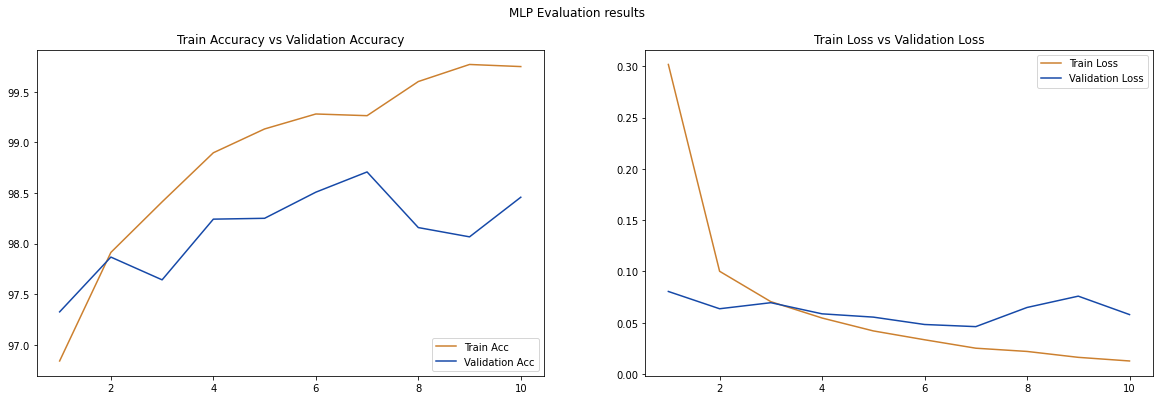

In [50]:
# Train each model
print("\n\nTraining MLP ...\n")
acccuracies, losses, val_accuracies, val_losses = trainModel(mlp)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))
fig.suptitle('MLP Evaluation results')
ax1.set_title("Train Accuracy vs Validation Accuracy")
ax1.plot(x, acccuracies, color="#cc802f", label="Train Acc")
ax1.plot(x, val_accuracies, color="#1649a8", label="Validation Acc")
ax1.legend(loc='lower right')
ax2.set_title("Train Loss vs Validation Loss")
ax2.plot(x, losses, color="#cc802f", label="Train Loss")
ax2.plot(x, val_losses, color="#1649a8", label="Validation Loss")
ax2.legend(loc='best')
plt.show()



Training CNN ...

Train Epoch: 1 [0 / 48000 (0%)]
Train Epoch: 1 [2000 / 48000 (4%)]
Train Epoch: 1 [4000 / 48000 (8%)]
Train Epoch: 1 [6000 / 48000 (12%)]
Train Epoch: 1 [8000 / 48000 (17%)]
Train Epoch: 1 [10000 / 48000 (21%)]
Train Epoch: 1 [12000 / 48000 (25%)]
Train Epoch: 1 [14000 / 48000 (29%)]
Train Epoch: 1 [16000 / 48000 (33%)]
Train Epoch: 1 [18000 / 48000 (38%)]
Train Epoch: 1 [20000 / 48000 (42%)]
Train Epoch: 1 [22000 / 48000 (46%)]
Train Epoch: 1 [24000 / 48000 (50%)]
Train Epoch: 1 [26000 / 48000 (54%)]
Train Epoch: 1 [28000 / 48000 (58%)]
Train Epoch: 1 [30000 / 48000 (62%)]
Train Epoch: 1 [32000 / 48000 (67%)]
Train Epoch: 1 [34000 / 48000 (71%)]
Train Epoch: 1 [36000 / 48000 (75%)]
Train Epoch: 1 [38000 / 48000 (79%)]
Train Epoch: 1 [40000 / 48000 (83%)]
Train Epoch: 1 [42000 / 48000 (88%)]
Train Epoch: 1 [44000 / 48000 (92%)]
Train Epoch: 1 [46000 / 48000 (96%)]
Epoch 1/10, Accuracy on train set: 98.35%
Train Epoch: 2 [0 / 48000 (0%)]
Train Epoch: 2 [2000 / 48000 

/home/danissa/anaconda2/envs/shadow/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  


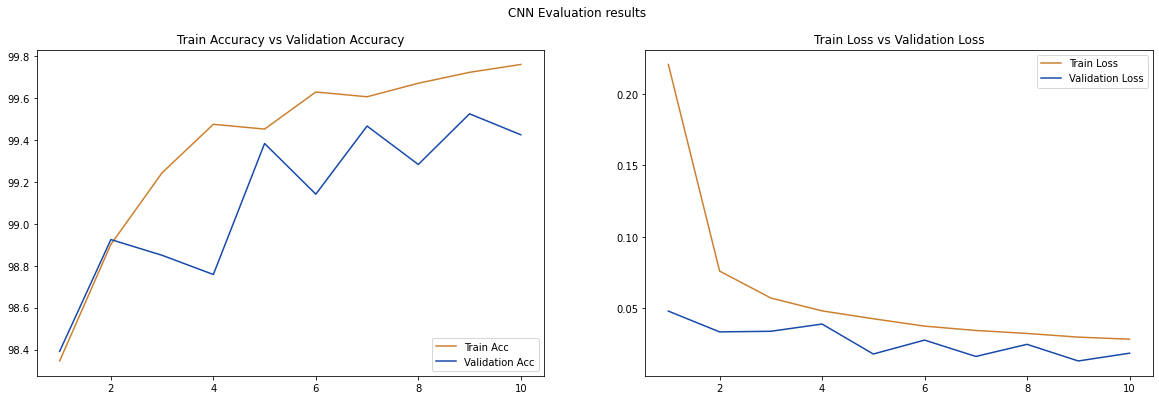

In [51]:
print("\n\nTraining CNN ...\n")
acccuracies, losses, val_accuracies, val_losses = trainModel(cnn)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))
fig.suptitle('CNN Evaluation results')
ax1.set_title("Train Accuracy vs Validation Accuracy")
ax1.plot(x, acccuracies, color="#cc802f", label="Train Acc")
ax1.plot(x, val_accuracies, color="#1649a8", label="Validation Acc")
ax1.legend(loc='lower right')
ax2.set_title("Train Loss vs Validation Loss")
ax2.plot(x, losses, color="#cc802f", label="Train Loss")
ax2.plot(x, val_losses, color="#1649a8", label="Validation Loss")
ax2.legend(loc='best')
plt.show()



Training RNN ...

Train Epoch: 1 [0 / 48000 (0%)]
Train Epoch: 1 [2000 / 48000 (4%)]
Train Epoch: 1 [4000 / 48000 (8%)]
Train Epoch: 1 [6000 / 48000 (12%)]
Train Epoch: 1 [8000 / 48000 (17%)]
Train Epoch: 1 [10000 / 48000 (21%)]
Train Epoch: 1 [12000 / 48000 (25%)]
Train Epoch: 1 [14000 / 48000 (29%)]
Train Epoch: 1 [16000 / 48000 (33%)]
Train Epoch: 1 [18000 / 48000 (38%)]
Train Epoch: 1 [20000 / 48000 (42%)]
Train Epoch: 1 [22000 / 48000 (46%)]
Train Epoch: 1 [24000 / 48000 (50%)]
Train Epoch: 1 [26000 / 48000 (54%)]
Train Epoch: 1 [28000 / 48000 (58%)]
Train Epoch: 1 [30000 / 48000 (62%)]
Train Epoch: 1 [32000 / 48000 (67%)]
Train Epoch: 1 [34000 / 48000 (71%)]
Train Epoch: 1 [36000 / 48000 (75%)]
Train Epoch: 1 [38000 / 48000 (79%)]
Train Epoch: 1 [40000 / 48000 (83%)]
Train Epoch: 1 [42000 / 48000 (88%)]
Train Epoch: 1 [44000 / 48000 (92%)]
Train Epoch: 1 [46000 / 48000 (96%)]
Epoch 1/10, Accuracy on train set: 96.22%
Train Epoch: 2 [0 / 48000 (0%)]
Train Epoch: 2 [2000 / 48000 

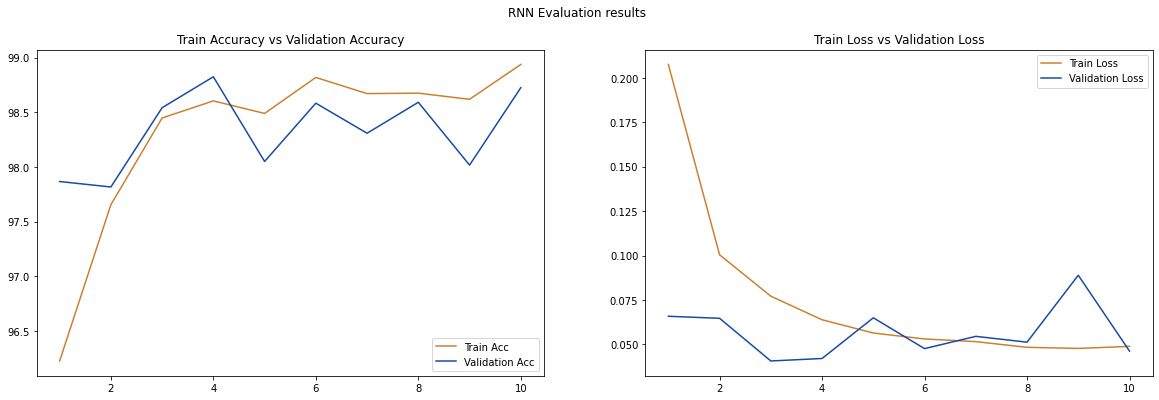

In [52]:
print("\n\nTraining RNN ...\n")
acccuracies, losses, val_accuracies, val_losses = trainModel(rnn)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))
fig.suptitle('RNN Evaluation results')
ax1.set_title("Train Accuracy vs Validation Accuracy")
ax1.plot(x, acccuracies, color="#cc802f", label="Train Acc")
ax1.plot(x, val_accuracies, color="#1649a8", label="Validation Acc")
ax1.legend(loc='lower right')
ax2.set_title("Train Loss vs Validation Loss")
ax2.plot(x, losses, color="#cc802f", label="Train Loss")
ax2.plot(x, val_losses, color="#1649a8", label="Validation Loss")
ax2.legend(loc='best')
plt.show()



Validating MLP ...


Validation set: Average loss: 0.0006, Accuracy: 98.46%

Confusion Matrix:
[[1195    3    0    0    0    0    0    0    2    0]
 [  12 1184    2    0    0    0    0    0    2    0]
 [   3    0 1192    2    0    3    0    0    0    0]
 [  11    1    1 1171    0    3    0   12    0    1]
 [   0    0    0    0 1194    3    0    0    1    2]
 [   2    9    5    1    9 1163    0    0   11    0]
 [   0    0    0    1    0    0 1153   46    0    0]
 [   0    0    0    2    0    0   26 1172    0    0]
 [   0    0    0    0    0    0    0    0 1200    0]
 [   1    0    0    0    1    0    6    1    0 1191]]


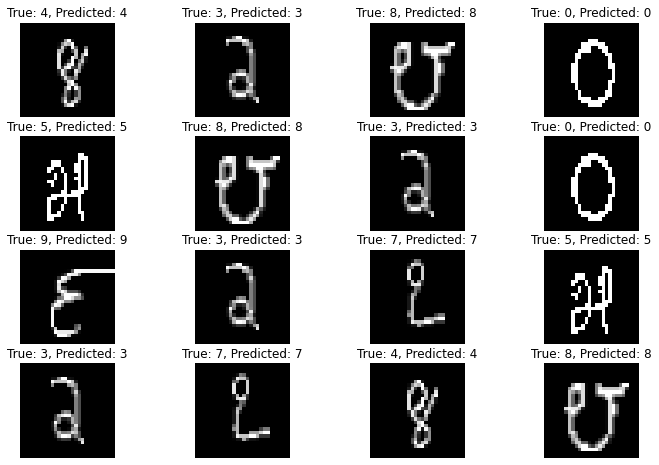

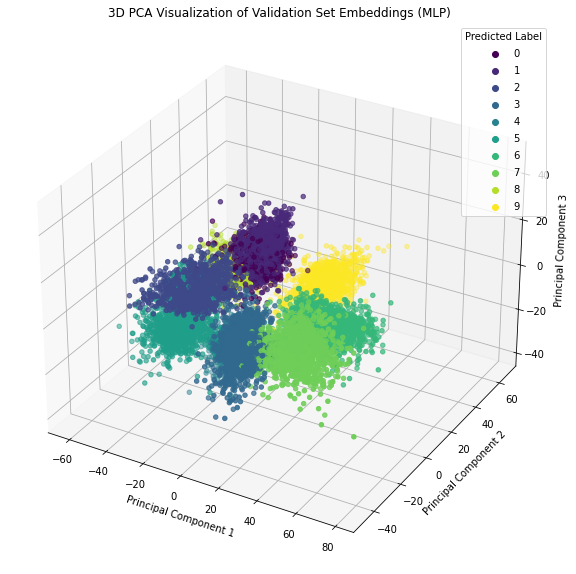

In [53]:
# Validate each model
print("\n\nValidating MLP ...\n")
validateModel(mlp)



Validating CNN ...


Validation set: Average loss: 0.0002, Accuracy: 99.42%

Confusion Matrix:
[[1198    2    0    0    0    0    0    0    0    0]
 [   8 1191    0    1    0    0    0    0    0    0]
 [   0    0 1200    0    0    0    0    0    0    0]
 [   0    0    0 1198    0    0    0    2    0    0]
 [   0    0    0    0 1197    3    0    0    0    0]
 [   3    5    0    0   17 1175    0    0    0    0]
 [   0    0    0    0    0    0 1185   15    0    0]
 [   0    0    0    5    0    0    4 1191    0    0]
 [   0    0    0    0    1    0    0    0 1199    0]
 [   0    0    0    0    0    0    3    0    0 1197]]


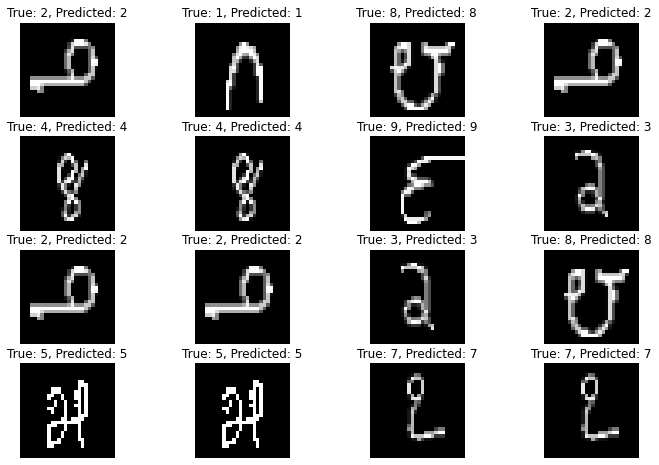

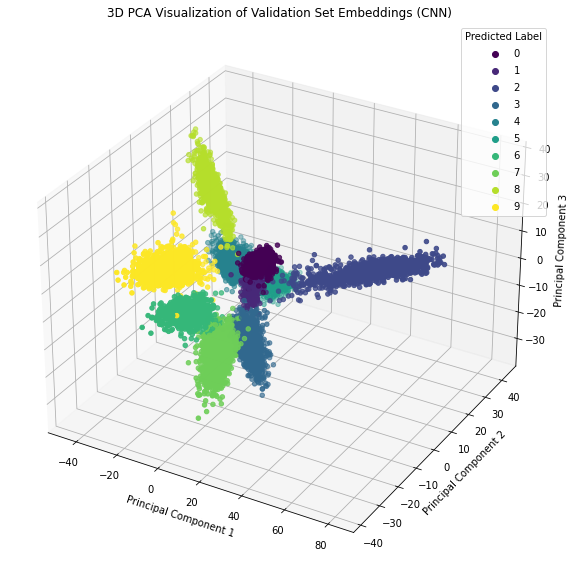

In [54]:
print("\n\nValidating CNN ...\n")
validateModel(cnn)



Validating RNN ...


Validation set: Average loss: 0.0005, Accuracy: 98.72%

Confusion Matrix:
[[1192    4    3    0    0    0    0    0    1    0]
 [   1 1196    1    0    1    0    0    1    0    0]
 [   1    0 1199    0    0    0    0    0    0    0]
 [   1    1    0 1184    2    0    1   11    0    0]
 [   0    0    0    1 1197    1    0    0    1    0]
 [   0    1    4    3   18 1173    0    1    0    0]
 [   0    0    0    0    0    0 1127   73    0    0]
 [   0    0    1    2    0    0   13 1184    0    0]
 [   0    0    0    0    0    0    0    0 1199    1]
 [   0    0    0    0    0    0    3    1    0 1196]]


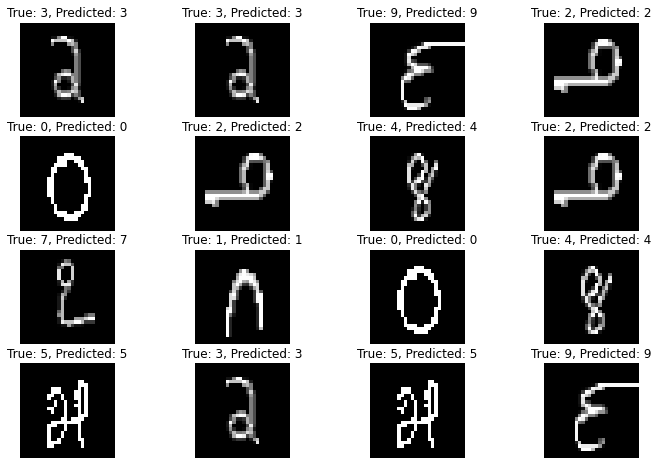

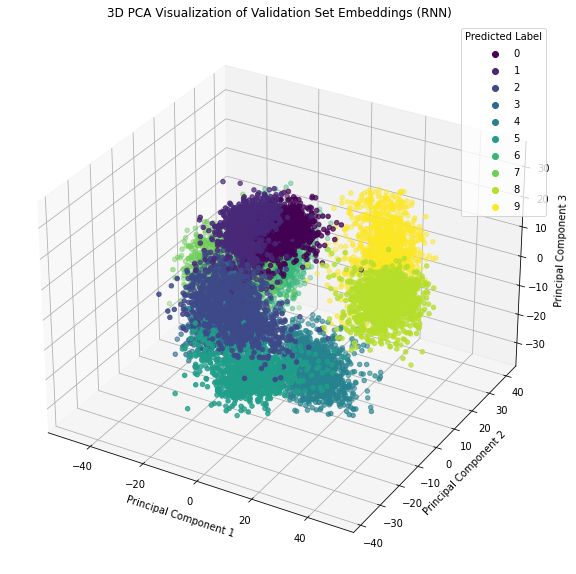

In [55]:
print("\n\nValidating RNN ...\n")
validateModel(rnn)

In [56]:
# Use the outputs from all three models to get the most accurate predictions
testOutputs = testModel(mlp)
testOutputs = testOutputs + testModel(cnn)
testOutputs = testOutputs + testModel(rnn)
testOutputs = np.argmax(testOutputs, axis=1)

In [57]:
# Save the test results to .csv for KAGGLE submission
ids = np.linspace(0, len(testOutputs)-1, len(testOutputs)).astype(int)
df = pd.DataFrame({'id': ids, 'label': testOutputs})
df.to_csv("submission.csv", index=False)